In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq
from scipy.stats import qmc

Problem 1

In [2]:
m_cluster = 100
gamma = -0.2
epsilon = 10**(-3)
delta = 0.01
k_cluster = 100
m = 500
r = 0.95
theta = np.pi/4
k_max = 250
dim = 2

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

boundaries = np.array([(-10,10) for _ in range (dim)])

Objective Function

In [3]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res += np.abs(f)
    return -1/(1+res)

In [4]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int, npoint: int, low=-10, high=10, sobol=True, seed=None):
    """
            Generates points within the specified bounds.

        Args:
            dim: Number of dimensions.
            npoint: Number of points to generate.
            low: Lower bound for each variable (scalar or list/numpy array).
            high: Upper bound for each variable (scalar or list/numpy array).
            sobol: Flag indicating whether to use Sobol sequence (True) or random sampling (False).

        Returns:
            A numpy array of size (npoint, dim) representing the generated points.
    """

    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')

    # Handle boundaries
    if type(low) == int:
        boundaries = [(low, high) for _ in range(dim)]
    elif type(low) in (list, np.ndarray):
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i], high[i]) for i in range(len(low))]

    # Generate points based on the sobol flag
    if sobol:
        sampler = qmc.Sobol(d=dim,scramble=True,seed=seed)
        sample = sampler.random(n=npoint)
        scaled_points = qmc.scale(sample=sample,l_bounds=low,u_bounds=high)

    else:
        # Generate random points
        np.random.seed(seed)
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points

In [5]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-6.03427149  0.13873326]] [10.]


c:\Users\ACER\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [6]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    global cluster_center, cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y
    
    cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    # # update radii if the existing corresponding cluster radii is larger than tha candidate
    # if cluster_radius[min_dist_id] > np.linalg.norm(y-xt):
    #     cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    
    # return cluster_center,cluster_radius


In [7]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("spo", r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Spiral Optimization\new\Spiropt.py")
# spo = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(spo)

import Spiropt as spo
import re
import importlib
importlib.reload(spo)

<module 'Spiropt' from 'd:\\OneDrive - Institut Teknologi Bandung\\[AKADEMIK]\\Semester 7-8\\TA\\Thesis\\Spiral Optimization\\new\\Spiropt.py'>

In [8]:
seed = np.random.randint(0,100)
print(f"seed={seed}")

while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])

    Rn = spo.generate_Rn(dim,theta)
    Sn = r*Rn
    iter_points[k+1] = spo.update_point(set_of_points=iter_points[k],
                                    objective_function=root_objective_function,
                                    Sn=Sn)

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")

seed=84


len(cluster_center)=80
cluster_center=[[-5.92541978  0.15620468]
 [ 0.68580616  0.70288218]
 [-0.36625459  0.14509662]
 [ 0.90476749  0.30067897]
 [-0.03745351  6.87008712]
 [-0.01785478  1.09083215]
 [ 0.45125251  0.83219883]
 [-4.8993141  -0.11372593]
 [-1.62025159  0.38391265]
 [-0.59419941  1.3756585 ]
 [-3.13938859 -0.02959135]
 [-1.70925132 -0.58635359]
 [-1.64991817  0.06049057]
 [ 1.516511    0.45860968]
 [ 1.108682    0.35332254]
 [-0.58100142  1.48444227]
 [-6.31738315 -0.1515593 ]
 [-5.26841528 -0.15582505]
 [-4.97926244 -0.12749621]
 [-3.42669786  0.011325  ]
 [-3.23515835 -0.01595257]
 [-6.7472646   0.11757598]
 [-3.38433066  0.07609778]
 [-5.54514929 -0.17024093]
 [-5.18751113 -0.14137413]
 [-5.26408947 -0.13953064]
 [-6.27238879  0.15826433]
 [-5.77087215 -0.16918367]
 [-5.47957271  0.14409387]
 [-4.98368792  0.1091067 ]
 [-5.65053657 -0.14653362]
 [-5.56290515 -0.14954557]
 [-5.12461553  0.05286148]
 [-5.00589196  0.08836097]
 [-5.68347631  0.14947875]
 [-4.83651335 -0.

Cluster Visualization

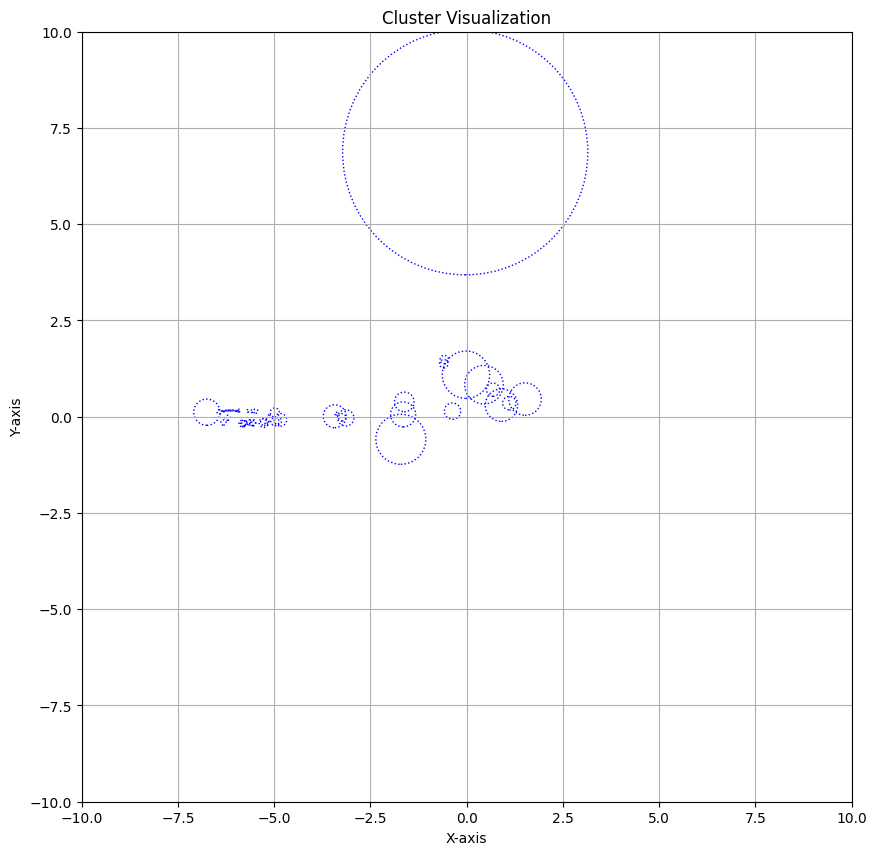

In [9]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [10]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


cluster_center[1] x answ[4]
cluster_center[4] x answ[2]
cluster_center[4] x answ[3]
cluster_center[6] x answ[4]
cluster_center[21] x answ[0]
cluster_center[38] x answ[0]


# Spiral Optimization Evaluation

In [11]:
archive = []
for i in range (len(cluster_center)):
    # subbound = np.array([cluster_center[i]-np.abs(cluster_radius[i]),cluster_center[i]+np.abs(cluster_radius[i])])
    subbound = np.array([[c-cluster_radius[i],c+cluster_radius[i]] for c in cluster_center[i]])
    root, root_score = spo.spiral_opt(objective_function=root_objective_function,
                                      boundaries=subbound,
                                      n_point=m,
                                      theta=theta,
                                      radius=r,
                                      max_iter=k_max,
                                      max_error=-1+epsilon,
                                      seed=None)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([-5.92863934,  0.15748572])]

====== Cluster 1 ======

Roots = [array([-5.92863934,  0.15748572]), array([0.66712119, 0.69010321])]

====== Cluster 2 ======

Roots = [array([-5.92863934,  0.15748572]), array([0.66712119, 0.69010321]), array([-0.16647065,  0.35663718])]

====== Cluster 3 ======

Roots = [array([-5.92863934,  0.15748572]), array([0.66712119, 0.69010321]), array([-0.16647065,  0.35663718]), array([0.66721897, 0.69000414])]

====== Cluster 4 ======

Roots = [array([-5.92863934,  0.15748572]), array([0.66712119, 0.69010321]), array([-0.16647065,  0.35663718]), array([0.66721897, 0.69000414]), array([0.16333332, 6.12243929])]

====== Cluster 5 ======

Roots = [array([-5.92863934,  0.15748572]), array([0.66712119, 0.69010321]), array([-0.16647065,  0.35663718]), array([0.66721897, 0.69000414]), array([0.16333332, 6.12243929]), array([0.58727422, 0.77487556])]

====== Cluster 6 ======

Roots = [array([-5.92863934,  0.15748572]), array([

[array([-5.92863934,  0.15748572]),
 array([0.66712119, 0.69010321]),
 array([-0.16647065,  0.35663718]),
 array([0.66721897, 0.69000414]),
 array([0.16333332, 6.12243929]),
 array([0.58727422, 0.77487556]),
 array([0.6671212, 0.6901032]),
 array([-4.97928235, -0.12396046]),
 array([-1.37204511,  0.62400997]),
 array([-0.70296921,  1.29556848]),
 array([-3.18170249e+00, -1.47848770e-03]),
 array([-1.57657841,  0.00586766]),
 array([-1.57854475,  0.38400556]),
 array([1.0962473, 0.4110715]),
 array([0.93407616, 0.46745842]),
 array([-0.61969341,  1.37616144]),
 array([-6.26426898, -0.15885339]),
 array([-5.38171557, -0.15953695]),
 array([-5.07677724, -0.13649732]),
 array([-3.18427957e+00,  1.32175136e-03]),
 array([-3.17988297, -0.00345633]),
 array([-6.43811785,  0.15532489]),
 array([-3.34565741,  0.04233921]),
 array([-5.6058613 , -0.16661537]),
 array([-5.2395212 , -0.15118535]),
 array([-5.33953894, -0.15741954]),
 array([-6.27257697,  0.15828584]),
 array([-5.83180784, -0.168019

In [12]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([[ 0.66712119,  0.69010321],
       [ 0.66721897,  0.69000414],
       [ 0.16333332,  6.12243929],
       [ 0.6671212 ,  0.6901032 ],
       [-6.43811785,  0.15532489],
       [-6.43716259,  0.15534788]])

In [13]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([[ 0.16333332,  6.12243929],
       [ 0.6671212 ,  0.6901032 ],
       [-6.43716259,  0.15534788]])

In [17]:
unique_roots

array([False, False,  True,  True, False,  True])